# Image clustering

## Imports

In [13]:
from enum import Enum, auto
from typing import Optional

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import rawpy
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from Uniforce import Uniforce
from data.enums.Algorithm_Over_Clustering import Algorithm_Over_Clustering
from data.options.SpanningTreeOptions import SpanningTreeOptions
from data.options.UniforceOptions import UniforceOptions

Algorithm_Over_Clustering.KmeansPp  # This is just so that auto import clean up won't remove the import of the Algorithms when we save the file and don't use the Algorithms class

<Algorithm_Over_Clustering.KmeansPp: 1>

### Image Helpers

In [14]:
class ImageType(Enum):
    JPG = auto()
    RAW = auto()


def load_image(path, imageType: ImageType = ImageType.JPG) -> Optional[np.ndarray]:
    match imageType:
        case ImageType.JPG:
            return imageio.v2.imread(path)
        case ImageType.RAW:
            return rawpy.imread(path).postprocess()
        case _:
            return None

### Load Image

In [15]:
img = load_image('C:\\Users\\Kostas\\Desktop\\george2.jpg')
img.shape

(4000, 6000, 3)

### Image Resize

In [16]:
image_scale_factor = 0.02
image_resized = resize(img, (int(img.shape[0] * image_scale_factor), int(img.shape[1] * image_scale_factor), 3),
                       anti_aliasing=True)
image_resized.shape

(80, 120, 3)

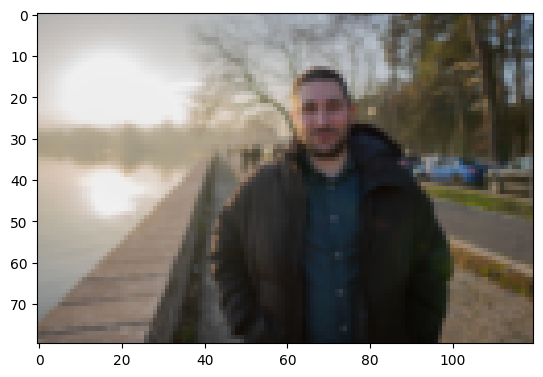

In [17]:
plt.imshow(image_resized)

### Executing UniForCE

In [18]:
options = UniforceOptions(spanning_tree_options=SpanningTreeOptions(alpha=1e-3),
                          algorithm_over_clustering=Algorithm_Over_Clustering.GlobalKMeansPpParallel)
image_resized = image_resized.astype('float32')
# Get the height and width of the image
height, width, channels = image_resized.shape

# Create a 2D array with color attributes and position
flattened_array = image_resized.reshape((height * width, channels))
position_array = np.indices((height, width)).reshape((2, -1)).T

# Extract the intensity channel (assuming it's grayscale)
intensity_channel = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY).reshape(-1, 1)

# Extract the saturation channel
saturation_channel = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)[:, :, 1].reshape(-1, 1)

# Normalize color attributes
scaler_color = MinMaxScaler()
normalized_colors = scaler_color.fit_transform(flattened_array)

# Normalize position information
scaler_position = MinMaxScaler()
normalized_positions = scaler_position.fit_transform(position_array)

# Normalize saturation
scaler_saturation = MinMaxScaler()
normalized_saturation = scaler_saturation.fit_transform(saturation_channel)

# Normalize intensity
scaler_intensity = MinMaxScaler()
normalized_intensity = scaler_intensity.fit_transform(intensity_channel)


In [19]:
uni1 = Uniforce(options).fit(normalized_colors)

Starting Over Clustering (GlobalKMeansPpParallel)...
Solving last 50-means.
Finished Over Clustering.
Starting Minimum Spanning Tree (Kruskal)...
Initializing edges...
Sorting edges...
Reassigning inactive sub clusters...
Recalculating sub cluster centers...
Connecting edges...
Finished Minimum Spanning Tree.


In [20]:
result_array = np.concatenate((normalized_positions, normalized_colors), axis=1)
uni2 = Uniforce(options).fit(result_array)

Starting Over Clustering (GlobalKMeansPpParallel)...
Solving last 50-means.
Finished Over Clustering.
Starting Minimum Spanning Tree (Kruskal)...
Initializing edges...
Sorting edges...
Reassigning inactive sub clusters...
Recalculating sub cluster centers...
Connecting edges...
Finished Minimum Spanning Tree.


In [21]:
result_array = np.concatenate((normalized_positions, normalized_colors, normalized_intensity, normalized_saturation),
                              axis=1)
uni3 = Uniforce(options).fit(result_array)

Starting Over Clustering (GlobalKMeansPpParallel)...
Solving last 50-means.
Finished Over Clustering.
Starting Minimum Spanning Tree (Kruskal)...
Initializing edges...
Sorting edges...
Reassigning inactive sub clusters...
Recalculating sub cluster centers...
Connecting edges...
Finished Minimum Spanning Tree.


In [22]:
from IPython.display import HTML

HTML(
    '<h3>Number of clusters with color only : {}</br>Number of clusters with position + color: {}</br>Number of clusters with p + c + saturation: {}</br></h3>'.format(
        uni1.n_clusters, uni2.n_clusters, uni3.n_clusters))

### Draw image with cluster colors

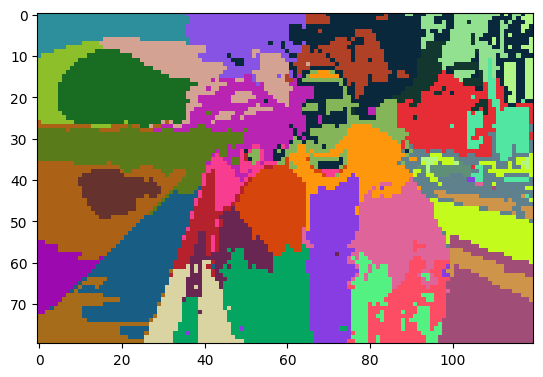

In [23]:
random_colors = np.random.rand(uni3.n_clusters, 3)

custom_colormap = plt.cm.colors.ListedColormap(random_colors)

plt.imshow(uni3.labels.reshape(image_resized.shape[0], image_resized.shape[1]), cmap=custom_colormap)

### Side by side comparison

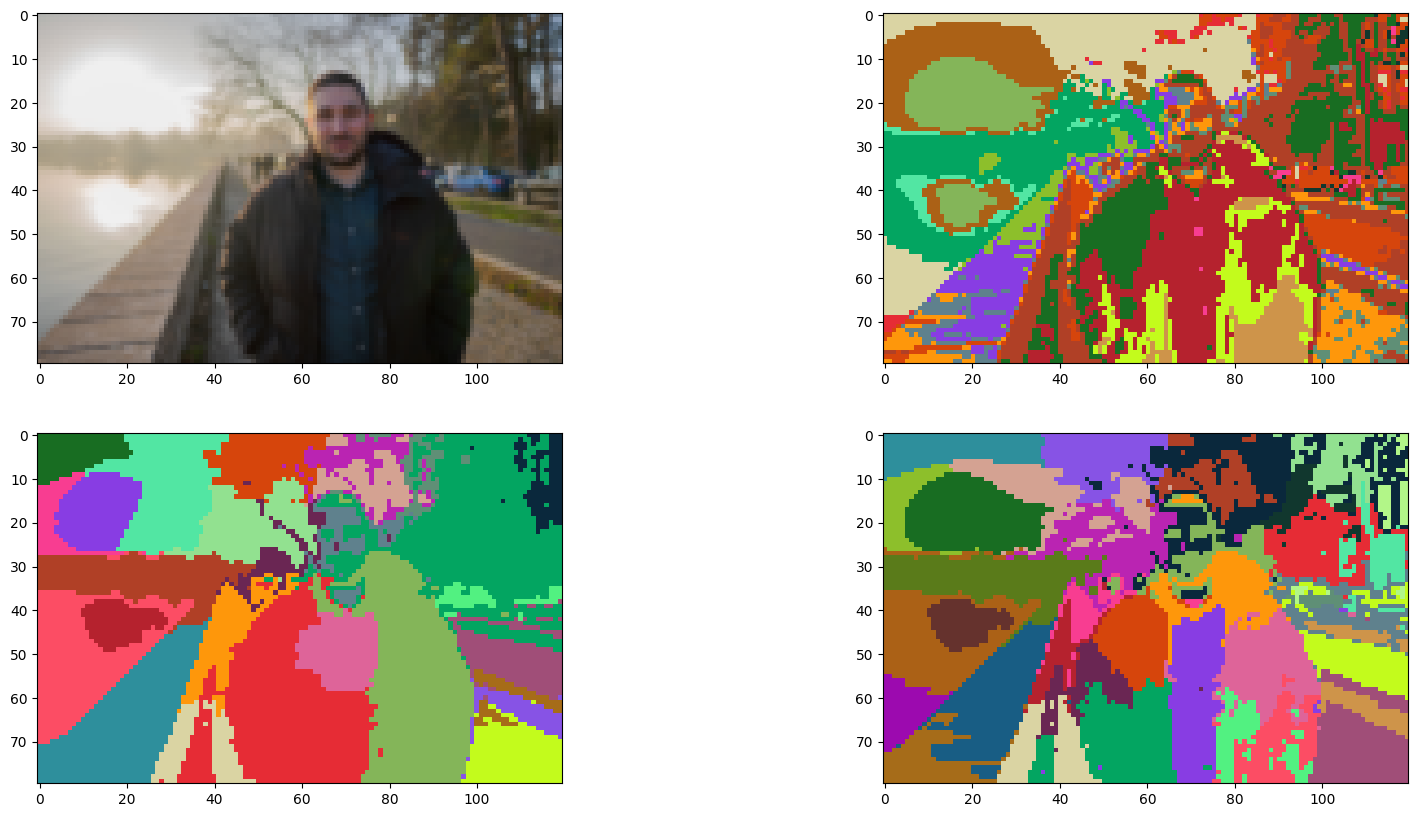

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0][0].imshow(image_resized)
ax[0][1].imshow(uni1.labels.reshape(image_resized.shape[0], image_resized.shape[1]), cmap=custom_colormap)
ax[1][0].imshow(uni2.labels.reshape(image_resized.shape[0], image_resized.shape[1]), cmap=custom_colormap)
ax[1][1].imshow(uni3.labels.reshape(image_resized.shape[0], image_resized.shape[1]), cmap=custom_colormap)
